In [10]:
import sys
import numpy as np
if sys.version_info < (3,5):
    raise Exception('Please use Python version 3.5 or greater.')
    
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
from scipy import linalg as la
from itertools import permutations
from functools import partial
import networkx as nx

# importing the QISKit
from qiskit import QuantumCircuit, QuantumProgram
#import Qconfig

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

# import optimization tools
from qiskit.tools.apps.optimization import trial_circuit_ry, SPSA_optimization, SPSA_calibration
from qiskit.tools.apps.optimization import Energy_Estimate, make_Hamiltonian, eval_hamiltonian, group_paulis
from qiskit.tools.qi.pauli import Pauli

In [11]:
n = 8 # number of data points to cluster

#contain the sample distances between data points
distance_dict = {}
distance_dict['plus'] = [0, 3, 4, 6]
distance_dict['minus'] = [2, 5, 7, 1]


dist_mat = np.zeros((8,8))
for i in range(0, 8):
    for j in range(0,8):
        if i == j :
            dist_mat[i, j] = 0
        elif i in distance_dict['plus']:
            for node in distance_dict['plus']:
                dist_mat[i, node] = 0.1
                dist_mat[i, i] = 0.
            for node in distance_dict['minus']:
                dist_mat[i, node] = 0.8
        elif i in distance_dict['minus']:
            for node in distance_dict['plus']:
                dist_mat[i, node] = 0.8
            for node in distance_dict['minus']:
                dist_mat[i, node] = 0.1
                dist_mat[i, i] = 0.

In [12]:
dist_mat

array([[0. , 0.8, 0.8, 0.1, 0.1, 0.8, 0.1, 0.8],
       [0.8, 0. , 0.1, 0.8, 0.8, 0.1, 0.8, 0.1],
       [0.8, 0.1, 0. , 0.8, 0.8, 0.1, 0.8, 0.1],
       [0.1, 0.8, 0.8, 0. , 0.1, 0.8, 0.1, 0.8],
       [0.1, 0.8, 0.8, 0.1, 0. , 0.8, 0.1, 0.8],
       [0.8, 0.1, 0.1, 0.8, 0.8, 0. , 0.8, 0.1],
       [0.1, 0.8, 0.8, 0.1, 0.1, 0.8, 0. , 0.8],
       [0.8, 0.1, 0.1, 0.8, 0.8, 0.1, 0.8, 0. ]])

/Users/arushigupta/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/arushigupta/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/arushigupta/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


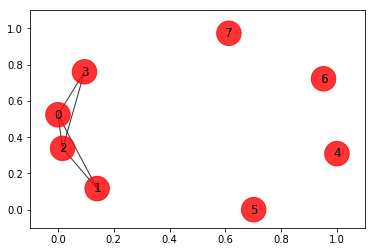

In [13]:


G=nx.Graph()
#add nodes to the graph
G.add_nodes_from(np.arange(0,n,1))

elist=[(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)
colors = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
default_axes.set_xlim(-0.1,1.1)
default_axes.set_ylim(-0.1,1.1)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes)

In [21]:
X_matr = np.random.rand(2, n)

In [16]:
pauli_list = []
for i in range(0, n):
    
    w = np.zeros(n)
    v = np.zeros(n)
    #w needs to always be 0
    v[i] = 1
    pauli_list.append((-1, Pauli(v, w)))

In [17]:
HB = make_Hamiltonian(pauli_list)

In [18]:
HB

array([[-8.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -6.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -6.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
       ...,
       [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  6.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  6.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  8.+0.j]])

In [26]:
Q = np.matmul(np.transpose(X_matr),X_matr)

In [27]:
Q

array([[0.64631747, 0.06747786, 0.64777548, 0.09408699, 0.481392  ,
        0.82527245, 0.53783323, 0.28419709],
       [0.06747786, 0.22086991, 0.315031  , 0.45948524, 0.14220588,
        0.44515736, 0.4048715 , 0.10422546],
       [0.64777548, 0.315031  , 0.93548592, 0.61456984, 0.58886278,
        1.24250159, 0.94252415, 0.37109938],
       [0.09408699, 0.45948524, 0.61456984, 0.95931167, 0.2634373 ,
        0.87508704, 0.81163314, 0.19815523],
       [0.481392  , 0.14220588, 0.58886278, 0.2634373 , 0.39808979,
        0.76905353, 0.55054339, 0.24373554],
       [0.82527245, 0.44515736, 1.24250159, 0.87508704, 0.76905353,
        1.65650427, 1.2722248 , 0.4880577 ],
       [0.53783323, 0.4048715 , 0.94252415, 0.81163314, 0.55054339,
        1.2722248 , 1.01627313, 0.35808266],
       [0.28419709, 0.10422546, 0.37109938, 0.19815523, 0.24373554,
        0.4880577 , 0.35808266, 0.15096124]])

In [ ]:
pauli_list = []
for i in range(0, n):
    for j in range(0, i):
    
    w = np.zeros(n)
    v = np.zeros(n)
    #w needs to always be 0
    v[i] = 1
    pauli_list.append((-1, Pauli(v, w)))